In [82]:
import numpy as np
from matplotlib import pyplot as plt

# RASPY: RoomAcousticS Toolbox in Python
The RoomAcoustics Toolbox in Python is a collection of functions for commonly used calculcations in room acoustics.
## 1 Getting Started
This is a short tutorial decribing the main functions of the toolbox.
### 1.1 Generate an Analytic Room Impulse Response
Let's calculate the transfer function of a rectangular room based on the analytic model [1].

In [74]:
from roomacoustics import analytic

Now we define the fundamental variables for the calculation of the room impulse response and hand this data to the function rectangular_room_rigid_walls(...):

In [75]:
sampling_rate = 44100
room_dimensions = [3, 2, 2]
src_pos = [1, 1.5, 2]
rec_pos = [2, 0.5, 1]
t_60 = 2
max_freq = 1000
n_samples = 2**18
speed_of_sound = 343.9

/Users/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


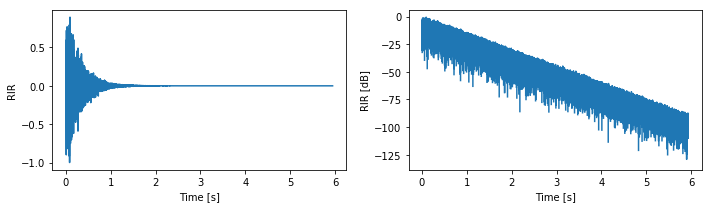

In [76]:
rir_1 = analytic.rectangular_room_rigid_walls(
    dimensions=room_dimensions, source=src_pos, receiver=rec_pos, reverberation_time=t_60, max_freq=max_freq,
    samplingrate=sampling_rate, speed_of_sound=speed_of_sound, n_samples=n_samples)[0]

rir_1 /= np.amax(np.abs(rir_1)) # Normalize 
time_vector = np.arange(0, n_samples) / sampling_rate

# Plot the result:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(time_vector, rir_1)
plt.xlabel('Time [s]')
plt.ylabel('RIR')
plt.subplot(122)
plt.plot(time_vector, 10*np.log10(rir_1))
plt.xlabel('Time [s]')
plt.ylabel('RIR [dB]')
plt.tight_layout()

### 1.2 Noise Compensation
For demonstrating the energy decay curve noise handling methods of the toolbox, it is necessary to introduce some noise on the channel.

/Users/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


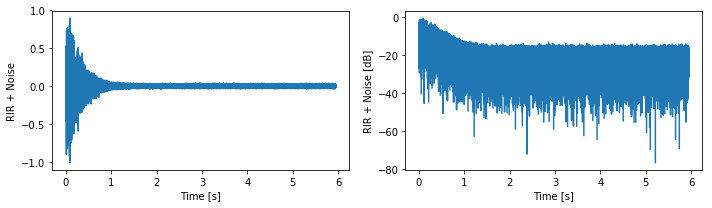

In [78]:
psnr = 50
rir_1_noise = rir_1 + 10**(-(psnr-10) / 20) * np.random.normal(0,1,rir_1.size)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(time_vector, rir_1_noise)
plt.xlabel('Time [s]')
plt.ylabel('RIR + Noise')
plt.subplot(122)
plt.plot(time_vector, 10*np.log10(rir_1_noise))
plt.xlabel('Time [s]')
plt.ylabel('RIR + Noise [dB]')
plt.tight_layout()

### 1.3 Estimate the Noise Energy of a RIR

In [65]:
import roomacoustics.edc_noise_handling as enh
import roomacoustics.roomacoustics as ra

In [79]:
noise_energy = enh.estimate_noise_energy(
    rir_1_noise, interval=[0.9, 1.0], is_energy=False)

noise_energy_db = 10*np.log10(noise_energy)
output_string = "The estimated noise is {} or {} dB.".format(noise_energy, noise_energy_db)
print(output_string)

The estimated noise is [0.00010044] or [-39.98113081] dB.


### 1.4 EDC Noise Compensation

The functions regarding EDC noise compensation of the toolbox always accept the following parameters:

    Parameters
    ----------
    data : ndarray, double
        The room impulse response with dimension [..., n_samples]
    sampling_rate: integer
        The sampling rate of the room impulse response.
    freq: integer OR string
        The frequency band. If set to 'broadband',
        the time window of the Lundeby-algorithm will not be set in dependence
        of frequency.
    is_energy: boolean
        Defines, if the data is already squared.
    time_shift : boolean
        Defines, if the silence at beginning of the RIR should be removed.
    channel_independent : boolean
        Defines, if the time shift and normalizsation is done
        channel-independently or not.
    normalize : boolean
        Defines, if the energy decay curve should be normalized in the end
        or not.
    plot: Boolean
        Specifies, whether the results should be visualized or not.

    Returns
    -------
    energy_decay_curve: ndarray, double
        Returns the noise handeled edc.

#### 1.4.1 Full Impulse Response
If the full RIR is considered for the EDC calculation, the plot below shows that the noise in the RIR introduces an error in the estimated EDC.

$$ E_{full}(t) = \int_t^{t_{IR}} h^2(\tau) d\tau  $$

$E(t)$ denotes the energy decay curve, $t$ the time, $t_{IR}$ the length of the impulse response and $h(\tau)$ the impulse response.



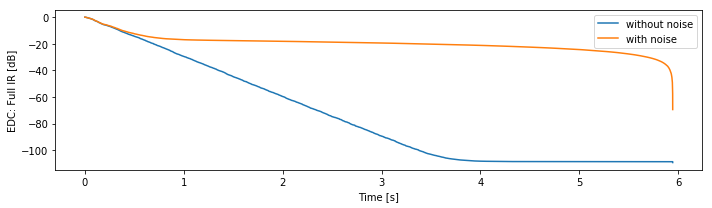

In [67]:
edc_full_rir = ra.schroeder_integration(rir_1_noise, is_energy=False)
edc_full_rir_compare = ra.schroeder_integration(rir_1, is_energy=False)
edc_full_rir /= edc_full_rir[0]
edc_full_rir_compare /= edc_full_rir_compare[0]

plt.figure(figsize=(10, 3))
plt.plot(time_vector, 10*np.log10(edc_full_rir_compare), label='without noise')
plt.plot(time_vector, 10*np.log10(edc_full_rir), label='with noise')
plt.xlabel('Time [s]')
plt.ylabel('EDC: Full IR [dB]')
plt.legend()
plt.tight_layout()

#### 1.4.2 Truncation

The RIR can be truncated to the intersection time $t_i$, where the decaying impulse response intersects with the estimated noise floor. The estimation of the intersection time after Lundeby et al. [2] is visualized below.

$$ E_{trunc}(t) = \int_t^{t_{i}} h^2(\tau) d\tau  $$

The estimated intersection time is [1.1466028]s, the late reverberation time is [2.13726879]s and the estimated noise is [-39.98331866]dB.


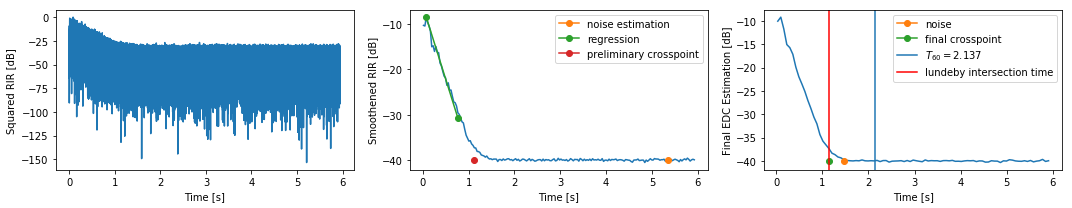

In [84]:
intersection_time, late_reveberation_time, noise_level = enh.intersection_time_lundeby(
        rir_1_noise, sampling_rate=sampling_rate, freq='broadband', is_energy=False,
        time_shift=False, channel_independent=False, plot=True)

output_string = "The estimated intersection time is {}s, the late reverberation time is {}s and the estimated noise is {}dB.".format(intersection_time, late_reveberation_time, noise_level)
print(output_string)

The next plot shows, how the noise error reduces significantly if the truncated RIR is utilized.

/Users/johannes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


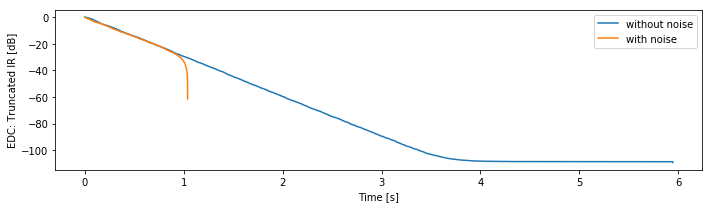

In [81]:
edc_truncation = enh.energy_decay_curve_truncation(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 3))
plt.plot(time_vector, 10*np.log10(edc_full_rir_compare), label='without noise')
plt.plot(time_vector, 10*np.log10(edc_truncation.T), label='with noise')
plt.xlabel('Time [s]')
plt.ylabel('EDC: Truncated IR [dB]')
plt.legend()
plt.tight_layout()

#### 1.4.3 Chu's Method

Chu [3] proposed a noise compensation method, where the noise energy is subtracted from the RIR in advance. This yields a even more noise compensated EDC.

$$ E(t)_{chu} = \int_t^{t_{IR}} (h^2(\tau) - N_{est}^2) d\tau  $$

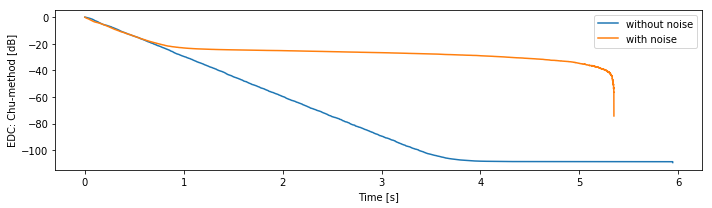

In [70]:
edc_chu = enh.energy_decay_curve_chu(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 3))
plt.plot(time_vector, 10*np.log10(edc_full_rir_compare), label='without noise')
plt.plot(time_vector, 10*np.log10(edc_chu.T), label='with noise')
plt.xlabel('Time [s]')
plt.ylabel('EDC: Chu-method [dB]')
plt.legend()
plt.tight_layout()

#### 1.4.4 Lundeby's Method

Lundeby et al. [2] proposed a noise compensation method, where the RIR is truncated to the intersection time and additionally intruced a correction term $C_{comp}$.

$$ E_{lundeby}(t) = \int_t^{t_i} h^2(\tau) d\tau + C_{comp}  $$

$$C_{comp} = p_{i}^2 * T_{60, late} * \frac{1}{6 * ln(10)} * R_s $$

$p_{i}^2$ denotes the squared sound pressure (?) at the intersection time, $T_{60, late}$ the late reverberation time after Lundeby and $R_s$ the sampling rate.

TO-DO: Reference for correction term?

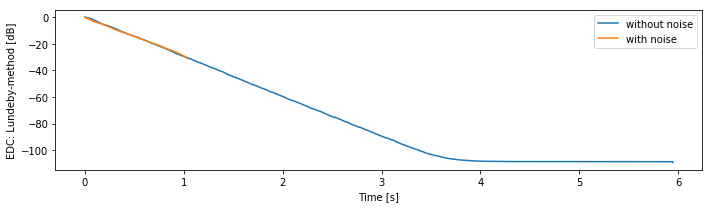

In [71]:
edc_lundeby = enh.energy_decay_curve_lundeby(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 3))
plt.plot(time_vector, 10*np.log10(edc_full_rir_compare), label='without noise')
plt.plot(time_vector, 10*np.log10(edc_lundeby.T), label='with noise')
plt.xlabel('Time [s]')
plt.ylabel('EDC: Lundeby-method [dB]')
plt.legend()
plt.tight_layout()

#### 1.4.5 Lundeby and Chu Combined

If all methods are combined, the influence of the noise can be minimized [4].

$$ E_{chu, lundeby}(t) = \int_t^{t_i} (h^2(\tau) - N_{est}^2) d\tau + C_{comp}  $$

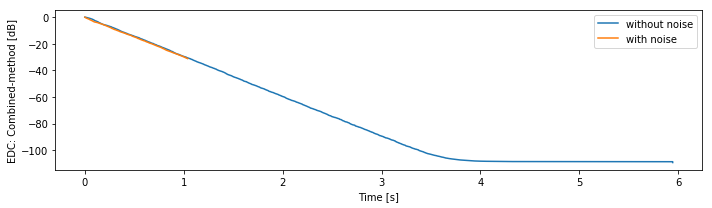

In [83]:
edc_chu_lundeby = enh.energy_decay_curve_chu_lundeby(
        rir_1_noise, sampling_rate, freq='broadband', is_energy=False, time_shift=True,
        channel_independent=False, normalize=True, plot=False)

plt.figure(figsize=(10, 3))
plt.plot(time_vector, 10*np.log10(edc_full_rir_compare), label='without noise')
plt.plot(time_vector, 10*np.log10(edc_chu_lundeby.T), label='with noise')
plt.xlabel('Time [s]')
plt.ylabel('EDC: Combined-method [dB]')
plt.legend()
plt.tight_layout()

## References
[1] H. Kuttruff, Room acoustics, pp. 64-66, 4th Ed. Taylor & Francis, 2009.

[2] Lundeby, Virgran, Bietz and Vorlaender - Uncertainties of Measurements in Room Acoustics - ACUSTICA Vol. 81 (1995)

[3] W. T. Chu. “Comparison of reverberation measurements using Schroeder’s impulse method and decay-curve averaging method”. In: Journal of the Acoustical Society of America 63.5 (1978), pp. 1444–1450.

[4] M. Guski, “Influences of external error sources on measurements of room acoustic parameters,” 2015.
